In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

import datasets, transforms, RajaramanModel, pytorch_msssim

# Flags:
flag_saveReportPictures = True # set to True to produce a batch of example images for writing reports and papers
flag_saveSuppressedImages = False # set to True to produce images for further AI training

# Paths
PATH_SAVE_NETWORK_INTERMEDIATE = "./runs/Rajaraman_ResNet/v1/network_intermediate.tar"
key_source = "source" # this is the dictionary key for the original radiograph in the datasets
key_boneless = "boneless" # this is the dictionary key for the bone-suppressed radiograph in the datasets file
# Data
_batch_size = 8
image_spatial_size = (256,256)

switch = "external_POLYU" #"internal"##

print("The dataset chosen is: " + switch)
if switch == "internal":
    directory_source = "D:/data/JSRT/augmented/test/source/"
    directory_boneless = "D:/data/JSRT/augmented/test/target/"
    keys_images = [key_source, key_boneless]
    ds = datasets.JSRT_CXR(directory_source, directory_boneless, 
                           transform=tvtransforms.Compose([
                                 transforms.RescalingNormalisation(keys_images,(0,1)),
                                 transforms.Rescale(image_spatial_size, keys_images, None),
                                 transforms.ToTensor(keys_images),
                                 ]))
elif switch == "external_POLYU":
    externalTest_directory = "D:/data/POLYU_COVID19_CXR_CT_Cohort1/cxr/CXR_PNG"
    keys_images = [key_source]
    ds = datasets.POLYU_COVID19_CXR_CT_Cohort1(externalTest_directory,
                                 transform=tvtransforms.Compose([
                                 transforms.RescalingNormalisation(keys_images,(0,1)),
                                 transforms.Rescale(image_spatial_size, keys_images, None),
                                 transforms.ToTensor(keys_images),
                                 ]))
else:
    raise RuntimeError("Dataset unknown.  Please input the details in the datasets.py file")
print(len(ds))
dl = DataLoader(ds, _batch_size, shuffle=True, num_workers=0)

# Select test 
sample = next(iter(dl))
print(sample[key_source].shape)

## Code for putting things on the GPU
ngpu = 1 #torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

The dataset chosen is: external_POLYU
1021
torch.Size([8, 1, 256, 256])
cpu


In [2]:
# Network
input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
net = RajaramanModel.ResNet_BS(input_array_size)
#net = nn.DataParallel(net, list(range(ngpu)))
if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
    print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
    checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE, map_location='cpu')
    start_epoch = checkpoint['epoch_next']
    reals_shown_now = checkpoint['reals_shown']
    net.load_state_dict(checkpoint['model_state_dict'])
    print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                        start_epoch, reals_shown_now))
else:
    print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
    raise RuntimeError("No checkpoint found at specified path.")

net = net.to(device)
# Set to testing mode
net.eval()

=> loading checkpoint './runs/Rajaraman_ResNet/v1/network_intermediate.tar'
=> loaded checkpoint './runs/Rajaraman_ResNet/v1/network_intermediate.tar' (epoch 86, reals shown 343312)


ResNet_BS(
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resModules): ModuleList(
    (0): res_block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): res_block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): res_block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): res_block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (4): res_block(
      (conv1): Conv2d(64, 64, ker

In [3]:
if flag_saveSuppressedImages:
    print("Saving a set of bone suppressed images")
    path_to_save_images = Path(os.path.join("bone_suppressed",switch))
    path_to_save_images.mkdir(parents=True, exist_ok=True)
    iters=0
    for ii, data in enumerate(dl):
        input_data = data[key_source].to(device)
        out = net(input_data)
        print(out.shape)
        print("Batch Number:" + str(ii))
        out = out.cpu()
        for image in out:
            savename = str(iters)+".png"
            vutils.save_image( image, os.path.join(path_to_save_images, savename))
            iters+=1

./runs/Rajaraman_ResNet/v1


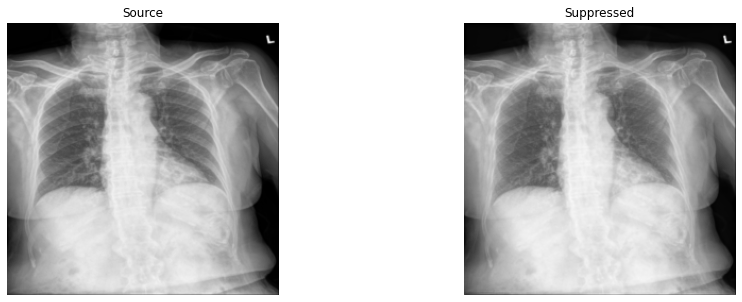

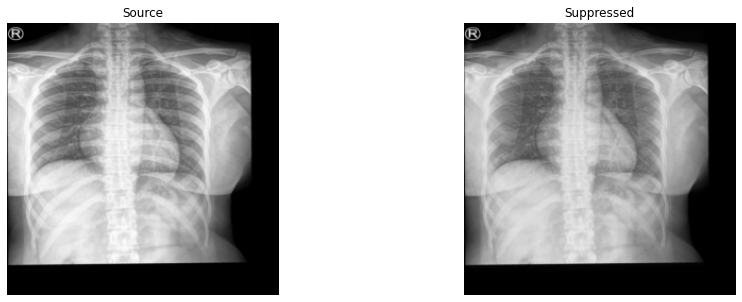

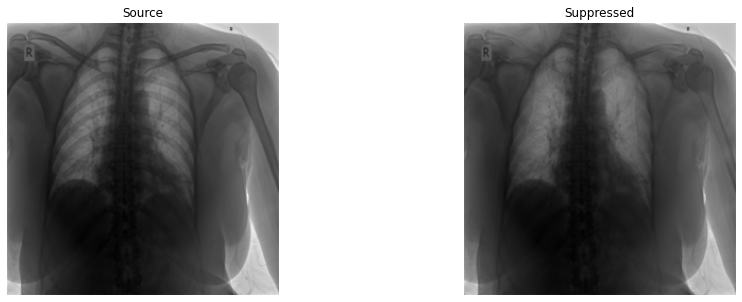

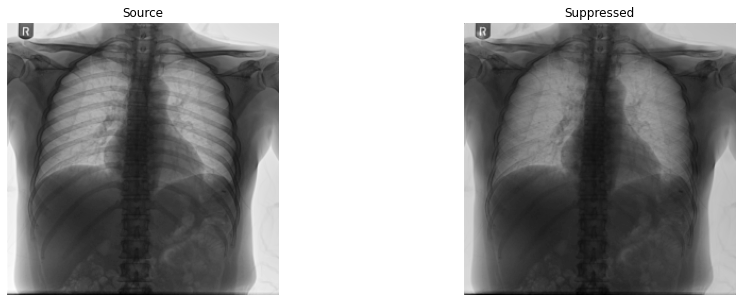

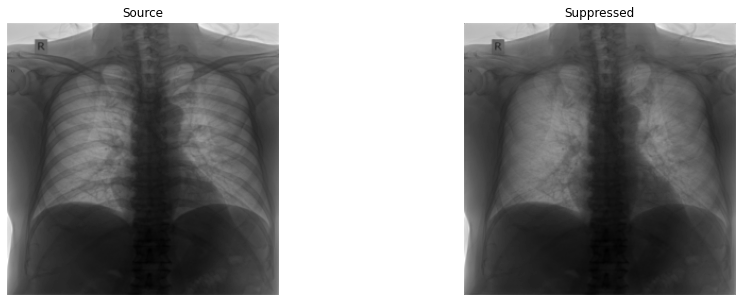

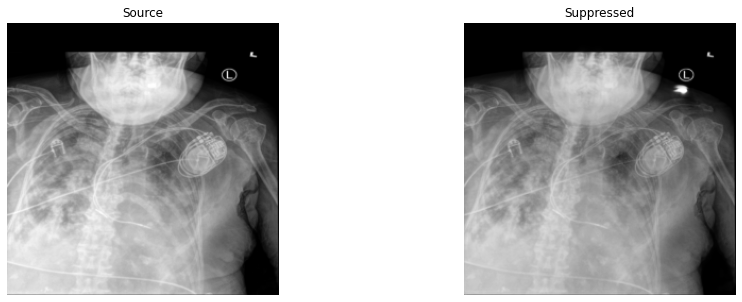

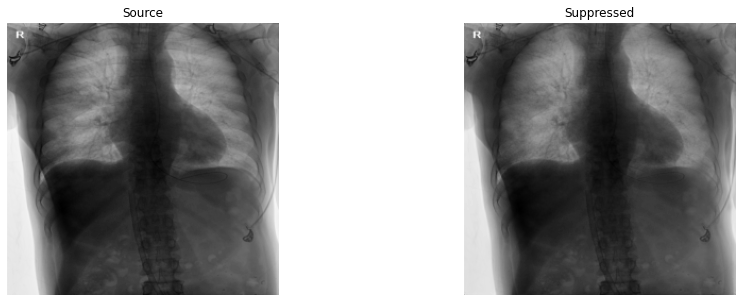

<Figure size 432x288 with 0 Axes>

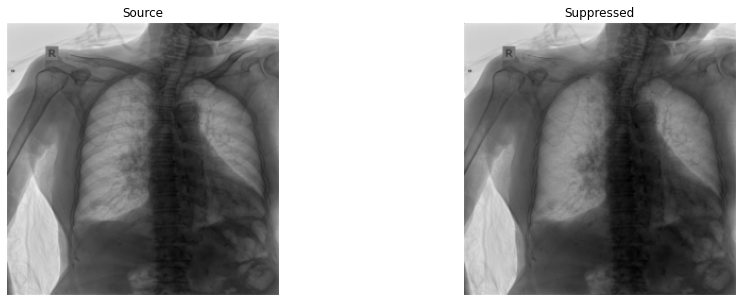

In [4]:
# Display
save_directory = os.path.split(PATH_SAVE_NETWORK_INTERMEDIATE)[0]
print(save_directory)

out = net(sample[key_source])
out = out.detach()
for batch_idx in range(_batch_size):
    if "boneless" in keys_images:
        plt.figure(1)
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        ax[0].imshow(sample["source"][batch_idx,0,:],cmap='gray')
        ax[0].set_title("Source")
        ax[0].axis("off")
        ax[1].imshow(out[batch_idx,0,:],cmap='gray')
        ax[1].set_title("Suppressed")
        ax[1].axis("off")
        ax[2].imshow(sample["boneless"][batch_idx,0,:],cmap='gray')
        ax[2].set_title("Ideal")
        ax[2].axis("off")
    else:
        plt.figure(1)
        fig, ax = plt.subplots(1,2, figsize=(15,5))
        ax[0].imshow(sample["source"][batch_idx,0,:],cmap='gray')
        ax[0].set_title("Source")
        ax[0].axis("off")
        ax[1].imshow(out[batch_idx,0,:],cmap='gray')
        ax[1].set_title("Suppressed")
        ax[1].axis("off")
    if flag_saveReportPictures:
        plt.savefig(os.path.join(save_directory, switch + "_comparisonImages_"+ str(batch_idx) +".png"))

In [5]:
# Analysis
def PSNR(image, reference, max_reference=1.):
    """ 
    Peak Signal-to-Noise Ratio
    Input image and reference assumed to be Torch Tensors of shape [NxCxHxW]
    """
    # Assume the image 
    H = image.size(-2)
    W = image.size(-1)
    MSE = (1/(H*W))*torch.sum((torch.abs(image - reference))**2, (-1,-2))
    rtMSE = torch.sqrt(MSE)
    
    output = 20*torch.log10(max_reference/rtMSE)
    return output.numpy().squeeze()

def NPS():
    """Noise Power Spectrum"""
    

def SSIM(image, reference):
    iters = 0
    out_list = np.ndarray(image.size(0))
    for im in image:
        im = im.numpy()
        im = np.moveaxis(im, 0,-1)
        ref = reference[iters,:].numpy()
        ref = np.moveaxis(ref, 0,-1)
        out = skimage.metrics.structural_similarity(im, ref, multichannel=True)
        out_list[iters]=out
        iters+=1
    return out_list

def MSE(image, reference):
    # Assume the image 
    H = image.size(-2)
    W = image.size(-1)
    MSE = (1/(H*W))*torch.sum((torch.abs(image - reference))**2, (-1,-2))
    out_list = np.squeeze(MSE.numpy())
    return out_list

psnr_dict={"source_to_boneless":[], "suppressed_to_boneless":[]}
ssim_dict={"source_to_boneless":[], "suppressed_to_boneless":[]}
MSE_dict ={"source_to_boneless":[], "suppressed_to_boneless":[]}
if "boneless" in keys_images:
    for sample in dl:
        # Neural network
        out = net(sample["source"])
        out = out.detach()
        
        psnr_dict["source_to_boneless"].append(PSNR(sample["source"], sample["boneless"]))
        psnr_dict["suppressed_to_boneless"].append(PSNR(out, sample["boneless"]))
        ssim_dict["source_to_boneless"].append(SSIM(sample["source"], sample["boneless"]))
        ssim_dict["suppressed_to_boneless"].append(SSIM(out, sample["boneless"]))
        MSE_dict["source_to_boneless"].append(MSE(sample["source"], sample["boneless"]))
        MSE_dict["suppressed_to_boneless"].append(MSE(out, sample["boneless"]))
#print("PSNR original: {} ; after denoising: {} ".format(PSNR(sample["source"], sample["boneless"]).mean(), PSNR(out, sample["boneless"]).mean()))
#print("SSIM original: {} ; after denoising: {} ".format(SSIM(sample["source"], sample["boneless"]).mean(), SSIM(out, sample["boneless"]).mean()))
print(os.path.split(PATH_SAVE_NETWORK_INTERMEDIATE))

('./runs/Rajaraman_ResNet/v1', 'network_intermediate.tar')


In [6]:
#print(psnr_dict)
print(str(np.concatenate(psnr_dict["source_to_boneless"]).mean()) + "," + str(np.concatenate(psnr_dict["suppressed_to_boneless"]).mean()))
print(str(np.concatenate(ssim_dict["source_to_boneless"]).mean()) + "," + str(np.concatenate(ssim_dict["suppressed_to_boneless"]).mean()))
print(str(np.mean(np.sqrt(np.concatenate(MSE_dict["source_to_boneless"])))) +","+ str(np.mean(np.sqrt(np.concatenate(MSE_dict["suppressed_to_boneless"])))))

ValueError: need at least one array to concatenate